# LSTM을 이용한 주가 예측

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib

In [2]:
# 데이터 다운로드
start = '2017-12-16'
end   = '2022-12-15'
KOSPI  = yf.download('^KS11', start, end) #KOSPI index

[*********************100%***********************]  1 of 1 completed


- 보통 6년치 데이터 다운로드 받음 (train : 5년, test : 1년)

In [3]:
KOSPI.shape

(1226, 6)

In [4]:
KOSPI.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-18,2488.830078,2488.830078,2477.290039,2481.879883,2481.879883,324400
2017-12-19,2487.830078,2498.669922,2470.489990,2478.530029,2478.530029,308400
2017-12-21,2471.340088,2471.729980,2429.830078,2429.830078,2429.830078,247300
2017-12-22,2437.590088,2444.570068,2426.939941,2440.540039,2440.540039,230400
2017-12-26,2447.669922,2457.189941,2427.340088,2427.340088,2427.340088,224600


In [5]:
kospi = KOSPI['Adj Close']   # 조정 종가

In [6]:
# 수익률과 비슷한 데이터 생성
kospi = np.log(kospi) - np.log(talib.EMA(kospi, 10)) 

- 10일치 EMA를 통해 최근 지수 반영

In [44]:
kospi

Date
2017-12-18         NaN
2017-12-19         NaN
2017-12-21         NaN
2017-12-22         NaN
2017-12-26         NaN
                ...   
2022-12-08   -0.017040
2022-12-09   -0.007775
2022-12-12   -0.011882
2022-12-13   -0.009946
2022-12-14    0.001070
Length: 1226, dtype: float64

In [45]:
yt = kospi.dropna()
yt

Date
2018-01-04    0.002836
2018-01-05    0.012542
2018-01-08    0.015382
2018-01-09    0.011577
2018-01-10    0.006045
                ...   
2022-12-08   -0.017040
2022-12-09   -0.007775
2022-12-12   -0.011882
2022-12-13   -0.009946
2022-12-14    0.001070
Length: 1217, dtype: float64

In [13]:
#!pip install statsmodels
#!pip install matplotlib

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

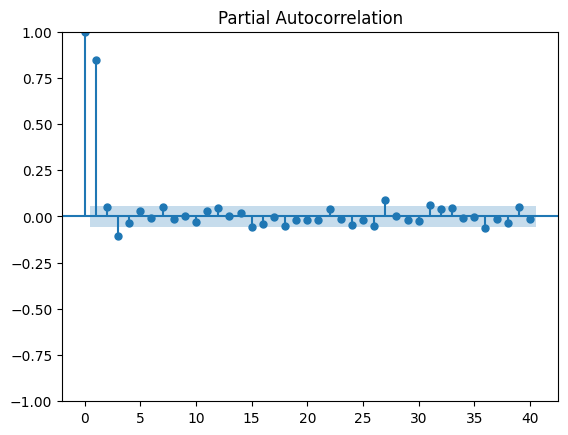

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(yt, lags=40, method='ols', title='Partial Autocorrelation').show

- 하늘색으로 색칠된 부분은 신뢰구간
- p = 3 일 때 구간 밖으로 나와있음 (뒤에 몇개 구간 밖에 것들은 노이즈로 취급)
=> p = 3으로 결정

In [16]:
yt_1 = yt.shift(1) # 1일 전 adjusted kospi
yt_2 = yt.shift(2) # 2일 전 adjusted kospi
yt_3 = yt.shift(3) # 3일 전 adjusted kospi

In [17]:
data = pd.concat([yt, yt_1,yt_2,yt_3], axis=1)

In [18]:
data.columns = ['yt', 'yt_1', 'yt_2', 'yt_3']

In [19]:
data = data.dropna()

In [20]:
data.head()

,yt,yt_1,yt_2,yt_3
Date,,,,
2018-01-09,0.011577,0.015382,0.012542,0.002836
2018-01-10,0.006045,0.011577,0.015382,0.012542
2018-01-11,0.001061,0.006045,0.011577,0.015382
2018-01-12,0.003661,0.001061,0.006045,0.011577
2018-01-15,0.005384,0.003661,0.001061,0.006045


In [21]:
y = data[['yt']]
x = data[['yt_1', 'yt_2', 'yt_3']]

In [22]:
y

,yt
Date,
2018-01-09,0.011577
2018-01-10,0.006045
2018-01-11,0.001061
2018-01-12,0.003661
2018-01-15,0.005384
...,...
2022-12-08,-0.017040
2022-12-09,-0.007775
2022-12-12,-0.011882


In [23]:
x

,yt_1,yt_2,yt_3
Date,,,
2018-01-09,0.015382,0.012542,0.002836
2018-01-10,0.011577,0.015382,0.012542
2018-01-11,0.006045,0.011577,0.015382
2018-01-12,0.001061,0.006045,0.011577
2018-01-15,0.003661,0.001061,0.006045
...,...,...,...
2022-12-08,-0.015853,-0.015008,-0.007441
2022-12-09,-0.017040,-0.015853,-0.015008
2022-12-12,-0.007775,-0.017040,-0.015853


In [28]:
#pip install sklearn
#!pip install scikit-learn

In [30]:
from sklearn import preprocessing

num_attrib =3
scaler_x = preprocessing.MinMaxScaler(feature_range = (-1, 1))
x = np.array(x).reshape((len(x), num_attrib))
x = scaler_x.fit_transform(x)

num_response = 1
scaler_y = preprocessing.MinMaxScaler(feature_range = (-1 , 1))
y = np.array(y).reshape((len(y), num_response))
y = scaler_y.fit_transform(y)

In [33]:
x.shape 

(1214, 3)

In [34]:
# train : 전체 데이터의 80%, test : 20% 
train_end = int((x.shape[0]*0.8))

In [35]:
train_end

971

In [36]:
data_end = len(y)

In [37]:
data_end

1214

In [38]:
x_train = x[0:train_end, ]
x_test  = x[train_end:data_end, ]
y_train = y[0:train_end]
y_test  = y[train_end:data_end]

# 2차원 -> 3차원으로 reshape for LSTM
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape [1])
x_test  = x_test.reshape(x_test.shape[0] , 1, x_test.shape [1])

print(" Shape of x_train is ", x_train.shape)
print(" Shape of x_test is ", x_test.shape)

 Shape of x_train is  (971, 1, 3)
 Shape of x_test is  (243, 1, 3)


In [49]:
#!pip install keras
#!pip install tensorflow

In [55]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
#from keras.layers.recurrent import LSTM

seed = 2016
np.random.seed (seed)

fit1 = Sequential()
fit1.add(LSTM(units = 4, # 수정가능
              activation = 'tanh',
              recurrent_activation = 'hard_sigmoid',
              input_shape =(1, 3)
             )
        )
fit1.add(Dense(units = 1, activation = 'linear'))

In [56]:
fit1.compile (loss ="mean_squared_error", optimizer ="rmsprop")  # Root Mean Sqaure Propagation

fit1.fit(x_train, y_train, batch_size =1, epochs =10, shuffle = True)

print(fit1.summary())

Epoch 1/10
971/971 [==============================] - 5s 3ms/step - loss: 0.0378
Epoch 2/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0105
Epoch 3/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0083
Epoch 4/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0074
Epoch 5/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0072
Epoch 6/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0069
Epoch 7/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0068
Epoch 8/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0067
Epoch 9/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0066
Epoch 10/10
971/971 [==============================] - 3s 3ms/step - loss: 0.0065
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None,

- 시계열 데이터를 3단위로 잘라 input으로 넣음
- 훈련이 3단위로 이루어짐 : 각 단위 내에서는 시계열로 이루어져있음
- shuffle을 해도 문제 없음, 성능이 더 높아짐

In [57]:
score_train = fit1.evaluate(x_train, y_train, batch_size =1)
score_test  = fit1.evaluate(x_test, y_test , batch_size =1)

print ("in train MSE = ", round(score_train, 4))
print ("in test MSE = ", round(score_test, 4))

243/243 [==============================] - 1s 2ms/step - loss: 0.0063
in train MSE =  0.0064
in test MSE =  0.0063


8/8 [==============================] - 1s 3ms/step


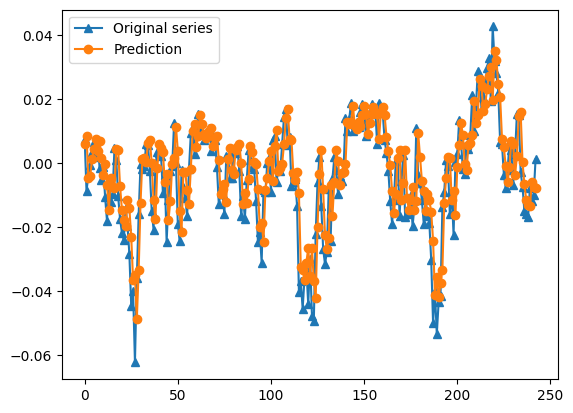

In [58]:
pred=fit1.predict(x_test)
pred1=scaler_y.inverse_transform(np.array(pred).reshape((len(pred),1)))
y_test1=scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test),1)))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(y_test1, marker = '^', label = "Original series")
plt.plot(pred1, marker = 'o', label = "Prediction")
plt.legend()

- 두 그래프가 거의 유사 : 예측 성공